A UNET-style neural network trained on the KITTI dataset to distinguish road pixels from all others -- this time rather than training all of the UNET from scratch, I'm using VGG weights as the encoder so it can use some of the transfer knowledge it has from imagenet. The decoder portion of the network will still be trained from scratch.

# Import and Setup

In [35]:
import tensorflow as tf
import os
import numpy as np
from scipy import misc
import sys
from random import shuffle
from random import uniform
import zipfile
from collections import OrderedDict
import glob
import time

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
train_dir = 'data_road/training'
test_dir = 'data_road/testing'
train_imgs_path = os.path.join(train_dir, 'image_2')
train_gt_path = os.path.join(train_dir, 'gt_image_2')
test_imgs_path = os.path.join(test_dir, 'image_2')
imgs = glob.glob(os.path.join(train_imgs_path, "*.png"))
gt = glob.glob(os.path.join(train_gt_path, "*road*.png"))
test_imgs = glob.glob(os.path.join(test_imgs_path, "*.png"))
imgs.sort()
gt.sort()

# downloaded into current directory from ftp://mi.eng.cam.ac.uk/pub/mttt2/models/vgg16.npy
vgg_path = 'vgg16.npy'
# From the VGG paper
vgg_means = [103.939, 116.779, 123.68]

# Utility Functions

In [3]:
def plot_image(image_path=None, img=None, from_path=True):
    if (from_path == True):
        img = misc.imread(image_path)
    if len(img.shape) == 4:
        img = np.squeeze(img)
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    plt.imshow(img)
    plt.show()

In [4]:
def prepare_ground_truth(img):
    # This will make it a two-channel binary image for two classes
    new_image = np.zeros((img.shape[0], img.shape[1], 2))
    blue_image = img[:,:,2]
    green_image = img[:,:,1]
    # Get the road marks by including only pixels that have blue
    # but don't have green (this will include the pink road but not
    # the red background or black)
    new_image[(blue_image > 0) * (green_image == 0), 1] = 1
    new_image[:, :, 0] = np.logical_not(new_image[:, :, 1]).astype(float)
    
    return new_image

In [5]:
# Get frequency figures for free space pixels vs. background pixels
# to properly weight cost function
# More info here: https://blog.fineighbor.com/tensorflow-dealing-with-imbalanced-data-eb0108b10701

total_road_pixs = 0
total_back_pixs = 0

# After looking through the data I noticed that some of the pictures are 370/Y and some are 375/Y
# so I'm standardizing them at the smaller size
row_size = 370
col_size = 1226

for i, label in enumerate(gt):
    im = misc.imread(label)
    if (im.shape[0] != row_size):
        im = im[im.shape[0]-row_size:,im.shape[1]-col_size:,:]
    im = prepare_ground_truth(im)
    size= im.shape[0]*im.shape[1]
    total_road_pixs += np.sum(im[:,:,1]) / size
    total_back_pixs += np.sum(im[:,:,0]) / size
    if (i % 100 == 0):
        print (i, " images calculated")

road_freq = total_road_pixs / len(gt)
back_freq = total_back_pixs / len(gt)

print("road freq is", road_freq)
print("back freq is", back_freq)

0  images calculated
100  images calculated
200  images calculated
road freq is 0.180677735995
back freq is 0.819322264005


In [6]:
# I noticed that it's having trouble dealing with shadows so this should
# help it become less reliant on color alone
def augment_image(image, augment_prob=0.75, max_delta=0.25):
    # decide whether to augment at all
    if (uniform(0, 1.0) > augment_prob):
        return image
    # add brightness/shadow
    # Altered to reflect vgg input specs
    add_brightness = uniform(-max_delta*255, max_delta*255)
    image += add_brightness
    im_range = np.abs(add_brightness) + 255.0
    image *= (255/im_range)
    if (add_brightness < 0):
        image += np.abs(add_brightness)
    return image

In [7]:
def get_train_batches(batch_size=1, augment=True, num_classes=2, mode='train', data_dir=train_imgs_path, labels_dir=train_gt_path):
    
    # Save last 40 images/labels for validation
    validation_size = 20
    
    imgs = glob.glob(os.path.join(data_dir, "*.png"))
    gt = glob.glob(os.path.join(labels_dir, "*road*.png"))
    
    imgs.sort()
    gt.sort()
    
    # Shuffle dataset
    combined = list(zip(imgs, gt))
    shuffle(combined)
    imgs[:], gt[:] = zip(*combined)
    
    if (mode == 'train'):
        imgs = imgs[:-validation_size]
        gt = gt[:-validation_size]
    elif (mode == 'validate'):
        imgs = imgs[-validation_size:]
        gt = gt[-validation_size:]
    else:
        raise ValueError("Unrecognized mode")
    
        
    # Import one image to check the size
    size_img = misc.imread(imgs[0])
    images = np.empty([len(imgs), row_size, col_size, size_img.shape[2]])
    labels = np.empty([len(gt), row_size, col_size, num_classes])
    
    # Handle pre-processing here
    for i, img in enumerate(imgs):
        im = misc.imread(img)
        if (im.shape[0] != row_size):
            im = im[im.shape[0]-row_size:,im.shape[1]-col_size:,:]
        # Note that image normalization has been removed to comply with
        # the input the vgg model is trained to expect
        if (mode=='train' and augment==True):
            im = augment_image(im.astype(np.float32))
        
        images[i,:,:,:] = im

    for i, label in enumerate(gt):
        im = misc.imread(label)
        if (im.shape[0] != row_size):
            im = im[im.shape[0]-row_size:,im.shape[1]-col_size:,:]
        labels[i,:,:,:] = prepare_ground_truth(im.astype(np.float32))
    
    while(True):
        for i in range(0,len(imgs),batch_size):
            yield(images[i:i+batch_size,:,:,:],labels[i:i+batch_size,:,:,:])

In [50]:
# After we have our prediction, we need a way to see it on the image
def visualize_prediction(original_image, prediction):
    
    original_image = np.squeeze(original_image).astype(np.uint8)
    prediction = np.squeeze(prediction)
    mask = np.argmax(prediction, axis=2)
    new_image = np.copy(original_image)
    new_image[mask[:,:] > 0, :] = [0, 255, 0]
    plt.imshow(new_image, interpolation='nearest')
    plt.show()

# Model-Building Functions

In [9]:
def vgg_conv(layer_input, vgg_dict, name):
    
    with tf.variable_scope(name):
        
        # Get the conv filter
        init = tf.constant_initializer(value=vgg_dict[name][0], dtype=tf.float32)
        shape = vgg_dict[name][0].shape
        filt = tf.get_variable(name="filter", initializer=init, shape=shape)
        # Get the conv bias
        init = tf.constant_initializer(value=vgg_dict[name][1], dtype=tf.float32)
        shape = vgg_dict[name][1].shape
        bias = tf.get_variable(name="biases", initializer=init, shape=shape)
        # Construct conv layer
        conv = tf.nn.conv2d(layer_input, filt, [1, 1, 1, 1], padding='SAME')	
        relu = tf.nn.relu(tf.nn.bias_add(conv, bias), name=name)

        return relu

In [10]:
# This comes straight out of the Unet paper
def get_stddev(filter_size, features):
    std = tf.sqrt(2 / ((filter_size**2) * features))
    return tf.cast(std, tf.float32)

In [11]:
# Helper function for deconvolutional layers
def deconv2d(x, W, stride, filters):
    x_shape = tf.shape(x)
    output_shape = tf.stack([x_shape[0], x_shape[1]*stride, x_shape[2]*stride, filters])
    return tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, stride, stride, 1], padding='SAME')

def deconv_layer(layer_input, input_fsize, output_fsize, stride, filter_size, name):
    w = tf.Variable(tf.truncated_normal(shape=[filter_size, filter_size, output_fsize, input_fsize], stddev=get_stddev(filter_size, input_fsize)), name=("filter_" + name))
    b = tf.Variable(tf.constant(0.1, shape=[output_fsize]))
    return tf.nn.relu(tf.add(deconv2d(layer_input, w, stride=4, filters=output_fsize), b))

In [12]:
def conv_layer(layer_input, input_fsize, output_fsize, filter_size, name):
    w = tf.Variable(tf.truncated_normal(shape=[filter_size, filter_size, input_fsize, output_fsize], stddev=get_stddev(filter_size, input_fsize)), name="filter_" + name)
    b = tf.Variable(tf.constant(0.1, shape=[output_fsize]))
    return tf.nn.relu(tf.add(tf.nn.conv2d(layer_input, w, strides=[1, 1, 1, 1], padding='SAME'), b))

In [13]:
def crop_to_x(x1,x2):
    x1_shape = tf.shape(x1)
    x2_shape = tf.shape(x2)
    # offsets for the top left corner of the crop
    offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2, 0]
    size = [-1, x2_shape[1], x2_shape[2], -1]
    return tf.slice(x1, offsets, size)

In [14]:
# Helper function for the resnet-like recombinations
# of previous layers with new ones, upscaled to the same size
# (This is where a lot of the magic of UNET is happening)
def crop_and_concat(x1,x2):
    x1_crop = crop_to_x(x1, x2)
    return tf.concat([x1_crop, x2], 3)

# Construct Model

In [21]:
def create_UNET_VGG(imgs, vgg_dict, dropout=0.5, channels=3, num_classes=2, filter_size=3):
    
    im_rows = tf.shape(imgs)[1]
    im_cols = tf.shape(imgs)[2]
    
    x_image = tf.reshape(imgs, tf.stack([-1,im_rows,im_cols,channels]))
    layer_input = x_image
    batch_size = tf.shape(x_image)[0]
    
    # VGG pre-processing
    red, green, blue = tf.split(x_image, 3, 3)

    x_image = tf.concat([
        blue - vgg_means[0],
        green - vgg_means[1],
        red - vgg_means[2]], axis=3)
    
    # Encoder
    conv1_1 = vgg_conv(imgs, vgg_dict, "conv1_1")
    conv1_2 = vgg_conv(conv1_1, vgg_dict, "conv1_2")
    pool1 = tf.nn.max_pool(conv1_2, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool1")
    conv2_1 = vgg_conv(pool1, vgg_dict, "conv2_1")
    conv2_2 = vgg_conv(conv2_1, vgg_dict, "conv2_2")
    pool2 = tf.nn.max_pool(conv2_2, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool2")
    conv3_1 = vgg_conv(pool2, vgg_dict, "conv3_1")
    conv3_2 = vgg_conv(conv3_1, vgg_dict, "conv3_2")
    conv3_3 = vgg_conv(conv3_2, vgg_dict, "conv3_3")
    pool3 = tf.nn.max_pool(conv3_3, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool3")
    conv4_1 = vgg_conv(pool3, vgg_dict, "conv4_1")
    conv4_2 = vgg_conv(conv4_1, vgg_dict, "conv4_2")
    conv4_3 = vgg_conv(conv4_2, vgg_dict, "conv4_3")
    pool4 = tf.nn.max_pool(conv4_3, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool4")
    conv5_1 = vgg_conv(pool4, vgg_dict, "conv5_1")
    conv5_2 = vgg_conv(conv5_1, vgg_dict, "conv5_2")
    conv5_3 = vgg_conv(conv5_2, vgg_dict, "conv5_3")
    pool5 = tf.nn.max_pool(conv5_3, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool5")

    # VGG depth at the fifth layer (comes from imported weights so
    # it will be constant no matter the size of input image)
    features = 512
        
    # Decoder
    # Deconvolutional layer 1   
    d_layer1 = deconv_layer(pool5, features, features//2, 4, filter_size, "decoder_d1")
    features = features // 2
    d_out1 = crop_and_concat(d_layer1, pool3)
    d_conv1 = conv_layer(d_out1, features*2, features, filter_size, "decoder_c1")

    # Deconvolutional layer 2  
    d_layer2 = deconv_layer(d_conv1, features, features//4, 4, filter_size, "decoder_d2")
    features = features // 4
    d_out2 = crop_and_concat(d_layer2, pool1)
    d_conv2 = conv_layer(d_out2, features*2, features, filter_size, "decoder_c2")

    # Deconvolutional layer 3
    d_layer3 = deconv_layer(d_conv2, features, num_classes, 2, filter_size, "decoder_d3")
    d_conv3 = conv_layer(d_layer3, num_classes, num_classes, filter_size, "decoder_c3")
    
    output = crop_to_x(d_conv3, x_image)
    
    all_vars = tf.trainable_variables()
    
    # Return variables as well for regularization
    return output, all_vars

In [26]:
class UNET_VGG:
    
    def __init__(self, channels=3, num_classes=2):
        
        # prediction path is to store validation prediction images in if necessary
        self.prediction_path = "predictions"
        self.output_path = "model"
        
        if not os.path.exists(self.prediction_path):
            os.mkdir(self.prediction_path)
        if not os.path.exists(self.output_path):
            os.mkdir(self.output_path)
                
        tf.reset_default_graph()
        
        self.num_classes = num_classes
        
        self.vgg_dict = np.load(vgg_path, encoding='latin1').item()
        
        self.x = tf.placeholder("float", shape=[None, None, None, channels])
        self.y = tf.placeholder("float", shape=[None, None, None, num_classes])
        self.drop_pl = tf.placeholder("float")

        logits, self.vars = create_UNET_VGG(self.x, self.vgg_dict, dropout=self.drop_pl, channels=channels, num_classes=num_classes)
        
        self.loss = self.get_loss(logits)
        
        self.predictor = self.pixel_wise_softmax(logits)
        
        # These two are for validation
        self.correct_pred = tf.equal(tf.argmax(self.predictor, 3), tf.argmax(self.y, 3))
        
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
    
    # A helper function for computing softmax across the channel-dimension as is necessary
    # with UNET
    def pixel_wise_softmax(self, output):
                
        # Softmax across the last dimension (where each channel is a binary image
        # denoting whether the pixel belongs in that category or not -- this allows
        # for more than two classes)
        # e^x
        exponential_map = tf.exp(output)
        # sum-e^x
        sum_exp = tf.reduce_sum(exponential_map, 3, keep_dims=True)
        # duplicate the last summed dimension
        tensor_sum_exp = tf.tile(sum_exp, tf.stack([1, 1, 1, tf.shape(output)[3]]))
        # divide e^x by sum-e^x 
        return tf.div(exponential_map, tensor_sum_exp)
        
    def get_loss(self, logits, loss_beta=.01):
                
        flat_logits = tf.reshape(logits, [-1, self.num_classes])
        flat_labels = tf.reshape(self.y, [-1, self.num_classes])
        
        # Make sure you're not dividing by zero
        eps = tf.constant(value=1e-10)
        flat_logits = flat_logits + eps
        
        softmax = tf.nn.softmax(flat_logits)
        
        # Weight the classes by their relative frequencies so the gradients
        # for less frequent classes don't vanish
        coeffs = tf.constant([(0.5/back_freq), (0.5/road_freq)])
        
        cross_entropy = -tf.reduce_sum(tf.multiply(flat_labels * tf.log(softmax + eps), coeffs), reduction_indices=[1])
        
        # Add regularization loss as well
        loss_L2 = tf.add_n([ tf.nn.l2_loss(v) for v in self.vars
                    if 'filter' in v.name ]) * loss_beta
        
        cost = tf.reduce_mean(tf.add(cross_entropy, loss_L2), name='cost')
        
        return cost
    
    def get_shape(self, img):
        
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            
            sess.run(init)
            
            prediction = sess.run(self.predictor, feed_dict={self.x: img, self.drop_pl: 1.0})

        return prediction.shape
    
    def predict(self, model_path, img, gt=None, restore=True):
    
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            
            sess.run(init)
            
            if restore:
                self.restore(sess, model_path)
            
            if gt != None:
                prediction, acc = sess.run([self.predictor, self.accuracy], feed_dict={self.x: img, self.y: gt, self.drop_pl: 1.0})
                return prediction, acc
            else:
                prediction = sess.run(self.predictor, feed_dict={self.x: img, self.drop_pl: 1.0})
                return prediction
    
    def save(self, sess, model_path):
        
        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path
    
    def restore(self, sess, model_path):
        
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
    
    def train(self, data_generator, output_path, dropout=0.5, training_iters=10, learning_rate=0.0001, epochs=10, display_step=10, restore=False, model_path=None):
        
        model_path = os.path.join(self.output_path, "unet.ckpt")
                
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            
            print("Session begun")
            
            sess.run(init)
        
            if restore:
                self.restore(sess, model_path)

            for epoch in range(epochs):
                
                print("Starting new epoch")
                
                total_loss = 0
                for step in range((epoch*training_iters), ((epoch+1)*training_iters)):
                    
                    x_batch, y_batch = next(data_generator)
                    
                    _, loss, _ = sess.run((self.optimizer, self.loss, self.vars),
                                                    feed_dict={self.x: x_batch,
                                                              self.y: y_batch,
                                                              self.drop_pl: dropout})
                    
                    total_loss += loss
                    
                    if (step % display_step == 0):
                        print("current loss =", loss)
                                            
                print("###############################")
                print("Epoch", epoch + 1, "average loss =", total_loss/training_iters)
                print("###############################")
                total_loss = 0                
                
            save_path = self.save(sess, model_path)
        
        return save_path

# Train Model

In [86]:
tf.reset_default_graph()

In [87]:
my_unet = UNET_VGG()

In [88]:
batch_generator = get_train_batches()
output_path = 'model'
model_path = 'unet_vgg_adv.ckpt'

In [1]:
model_path = my_unet.train(batch_generator, output_path, learning_rate=0.0005, training_iters=269, epochs=25, display_step=100, restore=True, model_path=model_path)


# Test Model

In [90]:
tf.reset_default_graph()

In [91]:
my_unet = UNET_VGG()

In [92]:
batch_generator = get_train_batches(mode='validate')

In [93]:
test_img, test_gt = next(batch_generator)

In [94]:
time1 = time.time()
supposed_pred, acc = my_unet.predict(model_path, test_img, gt=test_gt, restore=True)
time2 = time.time()
print ("It took ", (time2-time1)*1000, " miliseconds")

INFO:tensorflow:Restoring parameters from model/unet.ckpt


/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:97: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


It took  638.1793022155762  miliseconds


Accuracy = 0.81932


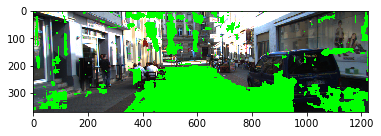

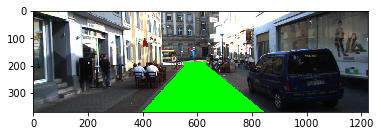

In [95]:
print("Accuracy =", acc)

visualize_prediction(test_img, supposed_pred)
visualize_prediction(test_img, test_gt)

# Evaluate Model

In [96]:
tf.reset_default_graph()

In [97]:
my_unet = UNET_VGG()

In [98]:
batch_generator = get_train_batches(mode='validate')

INFO:tensorflow:Restoring parameters from model/unet.ckpt


/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:97: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


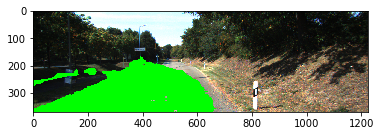

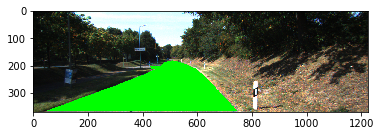

INFO:tensorflow:Restoring parameters from model/unet.ckpt


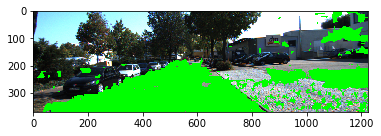

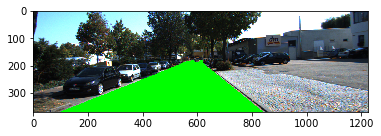

INFO:tensorflow:Restoring parameters from model/unet.ckpt


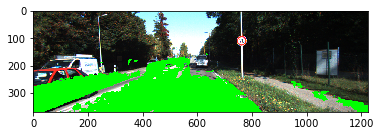

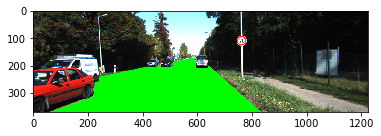

INFO:tensorflow:Restoring parameters from model/unet.ckpt


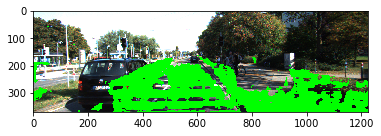

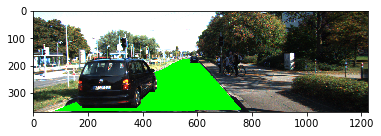

INFO:tensorflow:Restoring parameters from model/unet.ckpt


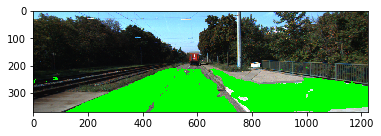

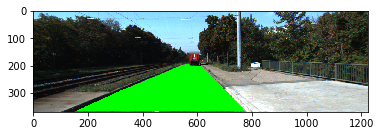

INFO:tensorflow:Restoring parameters from model/unet.ckpt


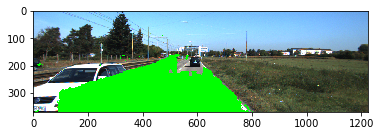

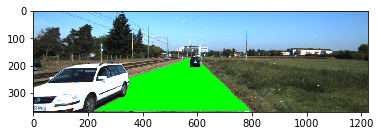

INFO:tensorflow:Restoring parameters from model/unet.ckpt


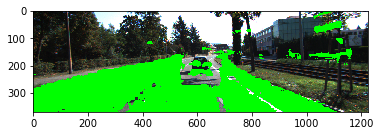

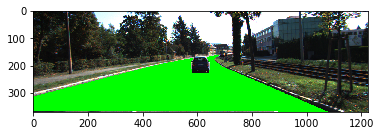

INFO:tensorflow:Restoring parameters from model/unet.ckpt


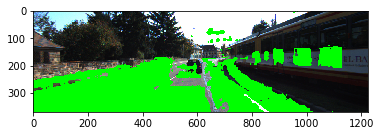

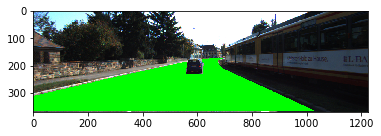

INFO:tensorflow:Restoring parameters from model/unet.ckpt


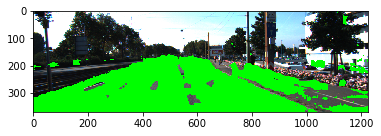

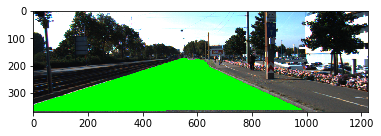

INFO:tensorflow:Restoring parameters from model/unet.ckpt


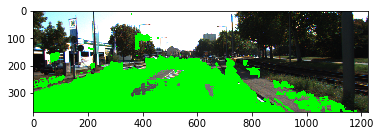

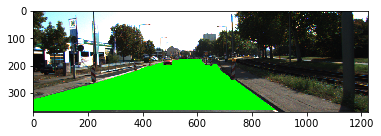

INFO:tensorflow:Restoring parameters from model/unet.ckpt


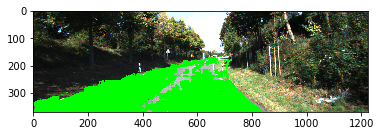

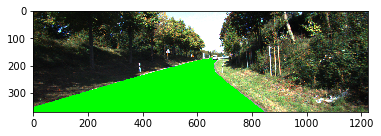

INFO:tensorflow:Restoring parameters from model/unet.ckpt


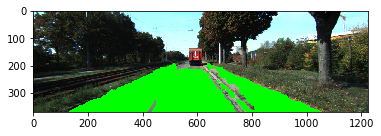

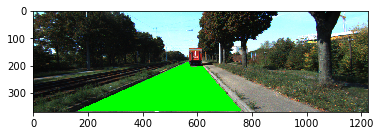

INFO:tensorflow:Restoring parameters from model/unet.ckpt


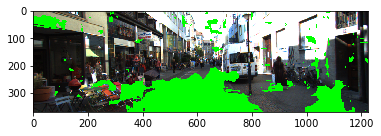

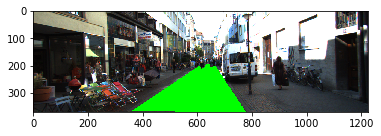

INFO:tensorflow:Restoring parameters from model/unet.ckpt


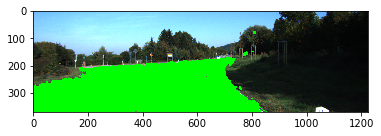

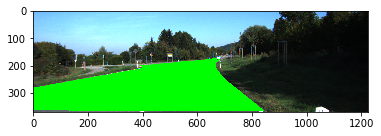

INFO:tensorflow:Restoring parameters from model/unet.ckpt


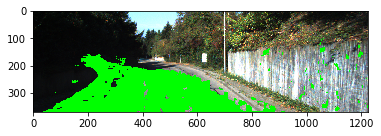

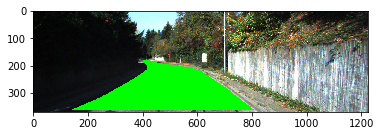

INFO:tensorflow:Restoring parameters from model/unet.ckpt


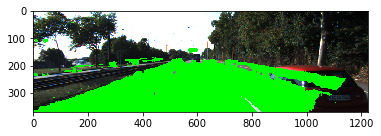

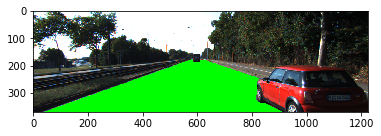

INFO:tensorflow:Restoring parameters from model/unet.ckpt


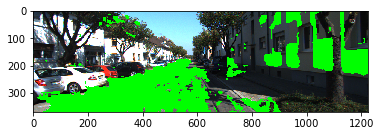

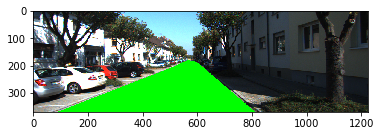

INFO:tensorflow:Restoring parameters from model/unet.ckpt


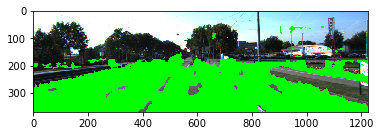

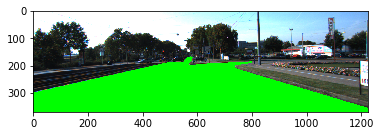

INFO:tensorflow:Restoring parameters from model/unet.ckpt


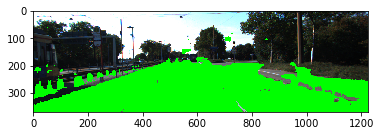

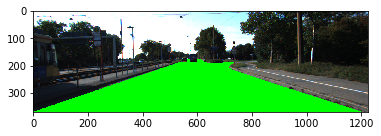

INFO:tensorflow:Restoring parameters from model/unet.ckpt


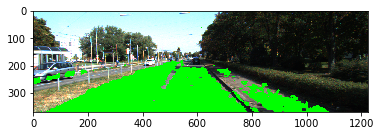

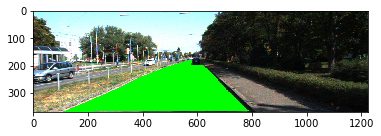

###############################
Average validation set accuracy = 0.894284898043
###############################


In [99]:
total_acc = 0.0
val_size = 20

for i in range(val_size):
    val_img, val_gt = next(batch_generator)
    results, acc = my_unet.predict(model_path, val_img, gt=val_gt, restore=True)
    total_acc += acc

    visualize_prediction(val_img, results)
    visualize_prediction(val_img, val_gt)

total_acc /= val_size
print("###############################")
print("Average validation set accuracy =", total_acc)
print("###############################")